# considrations :

- env : scanpy (version=1.10.4)


In [ ]:
#imports

import pandas as pd
import numpy as np

import seaborn as sns

import scanpy as sc
#from anndata import AnnData
import anndata


from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages  # Import PdfPages


from sklearn.cluster import KMeans

#import umap
#from umap import UMAP
#from sklearn.preprocessing import StandardScaler

import scipy.stats as stats

#from scipy.cluster.hierarchy import linkage, fcluster
#import time

print(sc.__version__)



1.10.4


In [2]:
# open the count matrix file for cleaned peaks:
input_file = "./merged_file.txt"
merged_df = pd.read_csv(input_file, sep="\t", index_col="region")
merged_df.index.name = None

# make and adata object from the merged_df so that the obs are the cells
transposed_df = merged_df.T
adata = sc.AnnData(transposed_df)

#display(adata)

# Split the observation names (index of adata.obs) by "_" for annotation of the cells
obs_names_split = adata.obs_names.str.split("_", expand=True)

# Add new columns to adata.obs
adata.obs["TR"] = obs_names_split.get_level_values(1)  # Second part (index 1)
adata.obs["condition"] = obs_names_split.get_level_values(2)  # Third part (index 2)
adata.obs["replicate"] = obs_names_split.get_level_values(3)  # Fourth part (index 3)
adata.obs['TR_Condition_initial'] = adata.obs['TR'].astype(str) + "_" + adata.obs['condition'].astype(str)

# some calculations for the cells (before filtering)
adata.obs['total_reads_percell'] = adata.X.sum(axis=1)
adata.obs['non_zero_peaks_percell'] = (adata.X != 0).sum(axis=1)

adata.obs['log1p_total_reads_percell'] = np.log1p(adata.obs['total_reads_percell'])
adata.obs['log1p_non_zero_peaks_percell'] = np.log1p(adata.obs['non_zero_peaks_percell'])

#display(adata.obs)
#print(obs_names_split)

# calculate some statistics about the counts (total read count and non zero count peaks)
adata.var['total_reads_perpeaks'] = adata.X.sum(axis=0)
adata.var['non_zero_cells_perpeaks'] = (adata.X != 0).sum(axis=0)

# Apply log1p transformation to 'peak_read_sum' and 'num_non_zero_cells'
adata.var['log1p_total_reads_perpeaks'] = np.log1p(adata.var['total_reads_perpeaks'])
adata.var['log1p_non_zero_cells_perpeaks'] = np.log1p(adata.var['non_zero_cells_perpeaks'])

#display(adata.var)

# open totalBAMreadsPerCell.txt as a dataframe
merged_df_totalreads = pd.read_csv("totalBAMreadsPerCell.txt", sep=" ", header=None, index_col=0)
merged_df_totalreads.index.name = None
# rename the column 1 to "totalReads"
merged_df_totalreads.columns = ["totalReads"]
#display(merged_df_totalreads)

# make the order of the index of merged_df_totalreads the same as the order of the adata.obs_names
merged_df_totalreads = merged_df_totalreads.reindex(adata.obs_names)
#display(merged_df_totalreads)

# add the merged_df_totalreads to the adata.obs
adata.obs["total_reads_BAM_percell"] = merged_df_totalreads["totalReads"].values

# FRiP calculation
adata.obs["FRiP"] = adata.obs['total_reads_percell']/adata.obs["total_reads_BAM_percell"]

display(adata.obs)


,TR,condition,replicate,TR_Condition_initial,total_reads_percell,non_zero_peaks_percell,log1p_total_reads_percell,log1p_non_zero_peaks_percell,total_reads_BAM_percell,FRiP
R15C43_NANOG_EpiLC_1_S826,NANOG,EpiLC,1,NANOG_EpiLC,298,13,5.700444,2.639057,606,0.491749
R19C52_OCT4_ESC_2_S2026,OCT4,ESC,2,OCT4_ESC,0,0,0.000000,0.000000,4,0.000000
R33C71_YAP1_ESC_1_S2618,YAP1,ESC,1,YAP1_ESC,0,0,0.000000,0.000000,0,NaN
R0C10_MYC_ESC_1_S386,MYC,ESC,1,MYC_ESC,6423,86,8.767796,4.465908,15046,0.426891
R65C23_YAP1_EpiLC_1_S2294,YAP1,EpiLC,1,YAP1_EpiLC,206,4,5.332719,1.609438,592,0.347973
...,...,...,...,...,...,...,...,...,...,...
R68C42_YAP1_EpiLC_2_S2512,YAP1,EpiLC,2,YAP1_EpiLC,591,7,6.383507,2.079442,2704,0.218565
R39C1_MYC_EpiLC_2_S317,MYC,EpiLC,2,MYC_EpiLC,23112,147,10.048151,4.997212,59418,0.388973
R61C25_OCT4_EpiLC_2_S1814,OCT4,EpiLC,2,OCT4_EpiLC,2826,43,7.946971,3.784190,8392,0.336749
R5C35_MYC_ESC_1_S446,MYC,ESC,1,MYC_ESC,2754,30,7.921173,3.433987,6442,0.427507


In [3]:
#count how many cells have NaN in the FRiP column
print(adata.obs['FRiP'].isna().sum())

print(adata.shape)

# Filter out cells with NaN in the FRiP column
adata = adata[~adata.obs['FRiP'].isna(), :]
print(adata.shape)

68
(2892, 24897)
(2824, 24897)


In [5]:
#to see the size of adata without 'YAP1'
adata[adata.obs['TR']!='YAP1']

View of AnnData object with n_obs × n_vars = 2117 × 24897
    obs: 'TR', 'condition', 'replicate', 'TR_Condition_initial', 'total_reads_percell', 'non_zero_peaks_percell', 'log1p_total_reads_percell', 'log1p_non_zero_peaks_percell', 'total_reads_BAM_percell', 'FRiP'
    var: 'total_reads_perpeaks', 'non_zero_cells_perpeaks', 'log1p_total_reads_perpeaks', 'log1p_non_zero_cells_perpeaks'

# separate the TF and conditions into 8 seperate adata


In [ ]:
# read the TFs sig peaks files and get the list of the sig peaks for each TF

# open the zscored filtered peaks IDs
MYC_sig_peaks = pd.read_csv("MYC_zscores_pvals_sig_REVIEW_NORMALIZED.txt", sep="\t", index_col="region")
NANOG_sig_peaks = pd.read_csv("NANOG_zscores_pvals_sig_REVIEW_NORMALIZED.txt", sep="\t", index_col="region")
OCT4_sig_peaks = pd.read_csv("OCT4_zscores_pvals_sig_REVIEW_NORMALIZED.txt", sep="\t", index_col="region")

MYC_sig_peaks.index.name = None
peaklist_Myc = MYC_sig_peaks.index.tolist()
print(MYC_sig_peaks.shape)

NANOG_sig_peaks.index.name = None
peaklist_Nanog = NANOG_sig_peaks.index.tolist()
print(NANOG_sig_peaks.shape)

OCT4_sig_peaks.index.name = None
peaklist_Oct4 = OCT4_sig_peaks.index.tolist()
print(OCT4_sig_peaks.shape)



(10048, 2)
(10328, 2)
(11041, 2)


In [7]:
#Filter the peack that are passed the z-score threshold for each TF
 
adata #['MYC', 'NANOG', 'OCT4', 'YAP1']

adata.layers['normalized'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=10000, layer='normalized', inplace=True)

adata_ESC_MYC_all = adata[(adata.obs['condition']=='ESC') & (adata.obs['TR']=='MYC'),:].copy()
adata_ESC_MYC = adata_ESC_MYC_all[:, peaklist_Myc].copy()

# some calculations for the cells (after zscore filtering)
adata_ESC_MYC.obs['total_reads_percell_zscored'] = adata_ESC_MYC.X.sum(axis=1)
adata_ESC_MYC.obs['non_zero_peaks_percell_zscored'] = (adata_ESC_MYC.X != 0).sum(axis=1)

adata_ESC_MYC.obs['log1p_total_reads_percell_zscored'] = np.log1p(adata_ESC_MYC.obs['total_reads_percell_zscored'])
adata_ESC_MYC.obs['log1p_non_zero_peaks_percell_zscored'] = np.log1p(adata_ESC_MYC.obs['non_zero_peaks_percell_zscored'])


adata_ESC_NANOG_all = adata[(adata.obs['condition']=='ESC') & (adata.obs['TR']=='NANOG'),:].copy()
adata_ESC_NANOG = adata_ESC_NANOG_all[:, peaklist_Nanog].copy()

# some calculations for the cells (after zscore filtering)
adata_ESC_NANOG.obs['total_reads_percell_zscored'] = adata_ESC_NANOG.X.sum(axis=1)
adata_ESC_NANOG.obs['non_zero_peaks_percell_zscored'] = (adata_ESC_NANOG.X != 0).sum(axis=1)

adata_ESC_NANOG.obs['log1p_total_reads_percell_zscored'] = np.log1p(adata_ESC_NANOG.obs['total_reads_percell_zscored'])
adata_ESC_NANOG.obs['log1p_non_zero_peaks_percell_zscored'] = np.log1p(adata_ESC_NANOG.obs['non_zero_peaks_percell_zscored'])


adata_ESC_OCT4_all = adata[(adata.obs['condition']=='ESC') & (adata.obs['TR']=='OCT4'),:].copy()
adata_ESC_OCT4 = adata_ESC_OCT4_all[:, peaklist_Oct4].copy()

# some calculations for the cells (after zscore filtering)
adata_ESC_OCT4.obs['total_reads_percell_zscored'] = adata_ESC_OCT4.X.sum(axis=1)
adata_ESC_OCT4.obs['non_zero_peaks_percell_zscored'] = (adata_ESC_OCT4.X != 0).sum(axis=1)

adata_ESC_OCT4.obs['log1p_total_reads_percell_zscored'] = np.log1p(adata_ESC_OCT4.obs['total_reads_percell_zscored'])
adata_ESC_OCT4.obs['log1p_non_zero_peaks_percell_zscored'] = np.log1p(adata_ESC_OCT4.obs['non_zero_peaks_percell_zscored'])


#adata_ESC_YAP1 = adata[(adata.obs['condition']=='ESC') & (adata.obs['TR']=='YAP1'),:].copy()

adata_EpiLC_MYC_all = adata[(adata.obs['condition']=='EpiLC') & (adata.obs['TR']=='MYC'),:].copy()
adata_EpiLC_MYC = adata_EpiLC_MYC_all[:, peaklist_Myc].copy()

# some calculations for the cells (after zscore filtering)
adata_EpiLC_MYC.obs['total_reads_percell_zscored'] = adata_EpiLC_MYC.X.sum(axis=1)
adata_EpiLC_MYC.obs['non_zero_peaks_percell_zscored'] = (adata_EpiLC_MYC.X != 0).sum(axis=1)

adata_EpiLC_MYC.obs['log1p_total_reads_percell_zscored'] = np.log1p(adata_EpiLC_MYC.obs['total_reads_percell_zscored'])
adata_EpiLC_MYC.obs['log1p_non_zero_peaks_percell_zscored'] = np.log1p(adata_EpiLC_MYC.obs['non_zero_peaks_percell_zscored'])


adata_EpiLC_NANOG_all = adata[(adata.obs['condition']=='EpiLC') & (adata.obs['TR']=='NANOG'),:].copy()
adata_EpiLC_NANOG = adata_EpiLC_NANOG_all[:, peaklist_Nanog].copy()

# some calculations for the cells (after zscore filtering)
adata_EpiLC_NANOG.obs['total_reads_percell_zscored'] = adata_EpiLC_NANOG.X.sum(axis=1)
adata_EpiLC_NANOG.obs['non_zero_peaks_percell_zscored'] = (adata_EpiLC_NANOG.X != 0).sum(axis=1)

adata_EpiLC_NANOG.obs['log1p_total_reads_percell_zscored'] = np.log1p(adata_EpiLC_NANOG.obs['total_reads_percell_zscored'])
adata_EpiLC_NANOG.obs['log1p_non_zero_peaks_percell_zscored'] = np.log1p(adata_EpiLC_NANOG.obs['non_zero_peaks_percell_zscored'])

adata_EpiLC_OCT4_all = adata[(adata.obs['condition']=='EpiLC') & (adata.obs['TR']=='OCT4'),:].copy()
adata_EpiLC_OCT4 = adata_EpiLC_OCT4_all[:, peaklist_Oct4].copy()

# some calculations for the cells (after zscore filtering)
adata_EpiLC_OCT4.obs['total_reads_percell_zscored'] = adata_EpiLC_OCT4.X.sum(axis=1)
adata_EpiLC_OCT4.obs['non_zero_peaks_percell_zscored'] = (adata_EpiLC_OCT4.X != 0).sum(axis=1)

adata_EpiLC_OCT4.obs['log1p_total_reads_percell_zscored'] = np.log1p(adata_EpiLC_OCT4.obs['total_reads_percell_zscored'])
adata_EpiLC_OCT4.obs['log1p_non_zero_peaks_percell_zscored'] = np.log1p(adata_EpiLC_OCT4.obs['non_zero_peaks_percell_zscored'])

#adata_EpiLC_YAP1 = adata[(adata.obs['condition']=='EpiLC') & (adata.obs['TR']=='YAP1'),:].copy()


print("MYC", adata_ESC_MYC_all.shape, adata_ESC_MYC.shape, adata_ESC_MYC.obs['FRiP'].isna().sum())
print("MYC", adata_EpiLC_MYC_all.shape, adata_EpiLC_MYC.shape, adata_EpiLC_MYC.obs['FRiP'].isna().sum())

print("NANOG", adata_ESC_NANOG_all.shape, adata_ESC_NANOG.shape, adata_ESC_NANOG.obs['FRiP'].isna().sum())
print("NANOG", adata_EpiLC_NANOG_all.shape, adata_EpiLC_NANOG.shape, adata_EpiLC_NANOG.obs['FRiP'].isna().sum())

print("OCT4", adata_EpiLC_MYC_all.shape, adata_ESC_OCT4.shape, adata_ESC_OCT4.obs['FRiP'].isna().sum())
print("OCT4", adata_EpiLC_OCT4_all.shape, adata_EpiLC_OCT4.shape, adata_EpiLC_OCT4.obs['FRiP'].isna().sum())

#print(adata_ESC_YAP1.shape)
#print(adata_EpiLC_YAP1.shape)




/var/folders/yv/0k5783m54kz5cltf2_077mrm0000gn/T/ipykernel_90351/3486663857.py:5: ImplicitModificationWarning: Setting element `.layers['normalized']` of view, initializing view as actual.
  adata.layers['normalized'] = adata.X.copy()
/Users/nadia/anaconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


MYC (344, 24897) (344, 10048) 0
MYC (377, 24897) (377, 10048) 0
NANOG (295, 24897) (295, 10328) 0
NANOG (401, 24897) (401, 10328) 0
OCT4 (377, 24897) (312, 11041) 0
OCT4 (388, 24897) (388, 11041) 0


# Filter
the way it is done by github code



In [ ]:

import anndata as ad

#
#sc.pl.violin(adata_ESC, keys="log1p_non_zero_peaks_percell", groupby='TR', rotation=90)

lpercentile = 15
hpercentile = 95

low_percentile = np.percentile(adata_ESC_MYC.obs['log1p_non_zero_peaks_percell'], lpercentile)
high_percentile = np.percentile(adata_ESC_MYC.obs['log1p_non_zero_peaks_percell'], hpercentile)
adata_ESC_MYC_filtered = adata_ESC_MYC[(adata_ESC_MYC.obs['log1p_non_zero_peaks_percell'] >= low_percentile) & (adata_ESC_MYC.obs['log1p_non_zero_peaks_percell'] <= high_percentile)].copy()
print("ESC_MYC :", adata_ESC_MYC.n_obs, adata_ESC_MYC_filtered.n_obs)

low_percentile = np.percentile(adata_ESC_NANOG.obs['log1p_non_zero_peaks_percell'], lpercentile)
high_percentile = np.percentile(adata_ESC_NANOG.obs['log1p_non_zero_peaks_percell'], hpercentile)
adata_ESC_NANOG_filtered = adata_ESC_NANOG[(adata_ESC_NANOG.obs['log1p_non_zero_peaks_percell'] >= low_percentile) & (adata_ESC_NANOG.obs['log1p_non_zero_peaks_percell'] <= high_percentile)].copy()
print("ESC_NANOG :", adata_ESC_NANOG.n_obs, adata_ESC_NANOG_filtered.n_obs)

low_percentile = np.percentile(adata_ESC_OCT4.obs['log1p_non_zero_peaks_percell'], lpercentile)
high_percentile = np.percentile(adata_ESC_OCT4.obs['log1p_non_zero_peaks_percell'], hpercentile)
adata_ESC_OCT4_filtered = adata_ESC_OCT4[(adata_ESC_OCT4.obs['log1p_non_zero_peaks_percell'] >= low_percentile) & (adata_ESC_OCT4.obs['log1p_non_zero_peaks_percell'] <= high_percentile)].copy()
print("ESC_OCT4 :", adata_ESC_OCT4.n_obs, adata_ESC_OCT4_filtered.n_obs)

#
# Concatenate AnnData objects along observations (rows, cells)
#adata_ESC_combined = ad.concat([adata_ESC_MYC_filtered, adata_ESC_NANOG_filtered, adata_ESC_OCT4_filtered, adata_ESC_YAP1_filtered], join="inner")
adata_ESC_combined = ad.concat([adata_ESC_MYC_filtered, adata_ESC_NANOG_filtered, adata_ESC_OCT4_filtered], join="inner") ##witthout YAP1


low_percentile = np.percentile(adata_EpiLC_MYC.obs['log1p_non_zero_peaks_percell'], lpercentile)
high_percentile = np.percentile(adata_EpiLC_MYC.obs['log1p_non_zero_peaks_percell'], hpercentile)
adata_EpiLC_MYC_filtered = adata_EpiLC_MYC[(adata_EpiLC_MYC.obs['log1p_non_zero_peaks_percell'] >= low_percentile) & (adata_EpiLC_MYC.obs['log1p_non_zero_peaks_percell'] <= high_percentile)].copy()
print("EpiLC_MYC :", adata_EpiLC_MYC.n_obs, adata_EpiLC_MYC_filtered.n_obs)

low_percentile = np.percentile(adata_EpiLC_NANOG.obs['log1p_non_zero_peaks_percell'], lpercentile)
high_percentile = np.percentile(adata_EpiLC_NANOG.obs['log1p_non_zero_peaks_percell'], hpercentile)
adata_EpiLC_NANOG_filtered = adata_EpiLC_NANOG[(adata_EpiLC_NANOG.obs['log1p_non_zero_peaks_percell'] >= low_percentile) & (adata_EpiLC_NANOG.obs['log1p_non_zero_peaks_percell'] <= high_percentile)].copy()
print("EpiLC_NANOG :", adata_EpiLC_NANOG.n_obs, adata_EpiLC_NANOG_filtered.n_obs)

low_percentile = np.percentile(adata_EpiLC_OCT4.obs['log1p_non_zero_peaks_percell'], lpercentile)
high_percentile = np.percentile(adata_EpiLC_OCT4.obs['log1p_non_zero_peaks_percell'], hpercentile)
adata_EpiLC_OCT4_filtered = adata_EpiLC_OCT4[(adata_EpiLC_OCT4.obs['log1p_non_zero_peaks_percell'] >= low_percentile) & (adata_EpiLC_OCT4.obs['log1p_non_zero_peaks_percell'] <= high_percentile)].copy()
print("EpiLC_OCT4 :", adata_EpiLC_OCT4.n_obs, adata_EpiLC_OCT4_filtered.n_obs)


# Concatenate AnnData objects along observations (rows, cells)
#adata_EpiLC_combined = ad.concat([adata_EpiLC_MYC_filtered, adata_EpiLC_NANOG_filtered, adata_EpiLC_OCT4_filtered, adata_EpiLC_YAP1_filtered], join="inner")
adata_EpiLC_combined = ad.concat([adata_EpiLC_MYC_filtered, adata_EpiLC_NANOG_filtered, adata_EpiLC_OCT4_filtered], join="inner") ##without YAP1


# Combine ESC and EpiLC
adata_combined = ad.concat([adata_ESC_combined, adata_EpiLC_combined], join="inner")

# FIX: Create a new column that combines 'TR' and 'Condition' for grouping
adata_combined.obs['TR_Condition'] = adata_combined.obs['TR'].astype(str) + "_" + adata_combined.obs['condition'].astype(str)



ESC_MYC : 344 274
ESC_NANOG : 295 235
ESC_OCT4 : 312 250
EpiLC_MYC : 377 302
EpiLC_NANOG : 401 321
EpiLC_OCT4 : 388 313


# plot umaps

In [9]:
##### combining ESC and EpiLC for each TF ###
#adata_EpiLC_combined = ad.concat([adata_EpiLC_MYC_filtered, adata_EpiLC_NANOG_filtered, adata_EpiLC_OCT4_filtered, adata_EpiLC_YAP1_filtered], join="inner")

### creating combined datasets:
# list of AnnData object:
ESC_Dataset=[adata_ESC_MYC_filtered, adata_ESC_NANOG_filtered, adata_ESC_OCT4_filtered] #, adata_ESC_YAP1_filtered]

EpiLC_Dataset=[adata_EpiLC_MYC_filtered, adata_EpiLC_NANOG_filtered, adata_EpiLC_OCT4_filtered] #, adata_EpiLC_YAP1_filtered]

tfs=["MYC","NANOG","OCT4"] #,"YAP1"]

#creating an empty dataset to store the merged data for corresponds to each TF
combined_filtered_dataset=[]

for i,tf in enumerate(tfs): # enumerates gives index an the coresponding value. useful as we have ESC and EpiLC for each tf.
    combined=ad.concat([ESC_Dataset[i], EpiLC_Dataset[i]],join="inner")
    combined_filtered_dataset.append(combined)

    globals()[f"adata_{tf}_filtered_combined"]=combined
    print(tf, "cobined, ECS, EpiLC", combined.shape , ESC_Dataset[i].shape, EpiLC_Dataset[i].shape)
    

# MYC (360, 24897) (360, 1984)
# MYC (385, 24897) (385, 1984)
# NANOG (299, 24897) (299, 3497)
# NANOG (401, 24897) (401, 3497)
# OCT4 (385, 24897) (318, 2666)
# OCT4 (390, 24897) (390, 2666)


MYC cobined, ECS, EpiLC (576, 10048) (274, 10048) (302, 10048)
NANOG cobined, ECS, EpiLC (556, 10328) (235, 10328) (321, 10328)
OCT4 cobined, ECS, EpiLC (563, 11041) (250, 11041) (313, 11041)


In [10]:
print("adata_combined : ", adata_combined)


adata_combined :  AnnData object with n_obs × n_vars = 1695 × 2018
    obs: 'TR', 'condition', 'replicate', 'TR_Condition_initial', 'total_reads_percell', 'non_zero_peaks_percell', 'log1p_total_reads_percell', 'log1p_non_zero_peaks_percell', 'total_reads_BAM_percell', 'FRiP', 'total_reads_percell_zscored', 'non_zero_peaks_percell_zscored', 'log1p_total_reads_percell_zscored', 'log1p_non_zero_peaks_percell_zscored', 'TR_Condition'
    layers: 'normalized'


In [11]:
#totalreadBAMcut = 5000

#tfs = ["MYC", "NANOG", "OCT4"] #, "YAP1"
#
#for tf in tfs:
#    adata_combined = globals()[f"adata_{tf}_filtered_combined"]
#    print(tf, adata_combined.shape)
#
#    # filter total_reads_BAM_percell > totalreadBAMcut for globals()[f"adata_{tf}_filtered_combined"]
#    adata_combined = adata_combined[adata_combined.obs["total_reads_BAM_percell"] > totalreadBAMcut, :]
#    print(tf, adata_combined.shape)
#
#    globals()[f"adata_{tf}_filtered_combined"] = adata_combined.copy()
#    print(tf, adata_combined.shape)
    


In [12]:
#print the number of non_zero_peaks_percell_zscored =0
print("MYC", (adata_ESC_MYC_filtered.obs['non_zero_peaks_percell_zscored']<2).sum())
print("MYC", (adata_EpiLC_MYC_filtered.obs['non_zero_peaks_percell_zscored']<2).sum())
print("NANOG", (adata_ESC_NANOG_filtered.obs['non_zero_peaks_percell_zscored']<2).sum())
print("NANOG", (adata_EpiLC_NANOG_filtered.obs['non_zero_peaks_percell_zscored']<2).sum())
print("OCT4", (adata_ESC_OCT4_filtered.obs['non_zero_peaks_percell_zscored']<2).sum())
print("OCT4", (adata_EpiLC_OCT4_filtered.obs['non_zero_peaks_percell_zscored']<2).sum())



MYC 17
MYC 6
NANOG 0
NANOG 21
OCT4 0
OCT4 7


MYC combined shape: (576, 10048)
MYC cleaned shape: (576, 10048)


/Users/nadia/anaconda3/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/yv/0k5783m54kz5cltf2_077mrm0000gn/T/ipykernel_90351/4165986260.py:46: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_filtered_combined_clean, resolution=0.9, random_state=42)  # Adjust resolution as needed


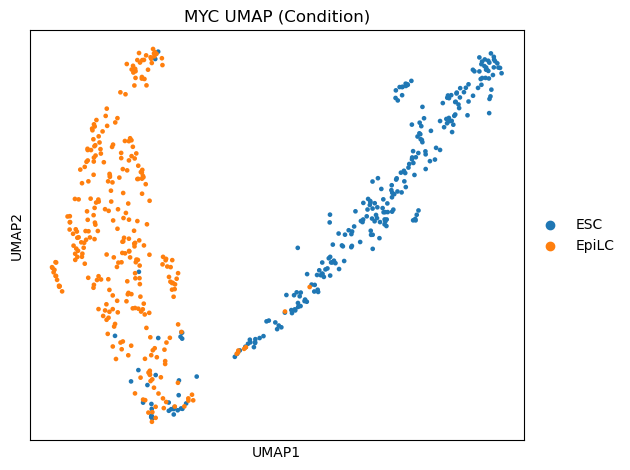

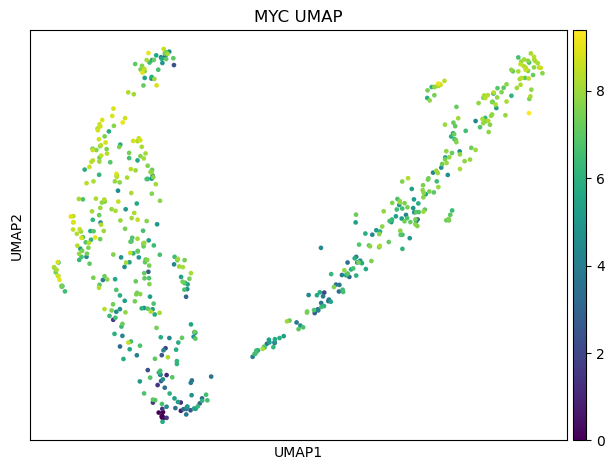

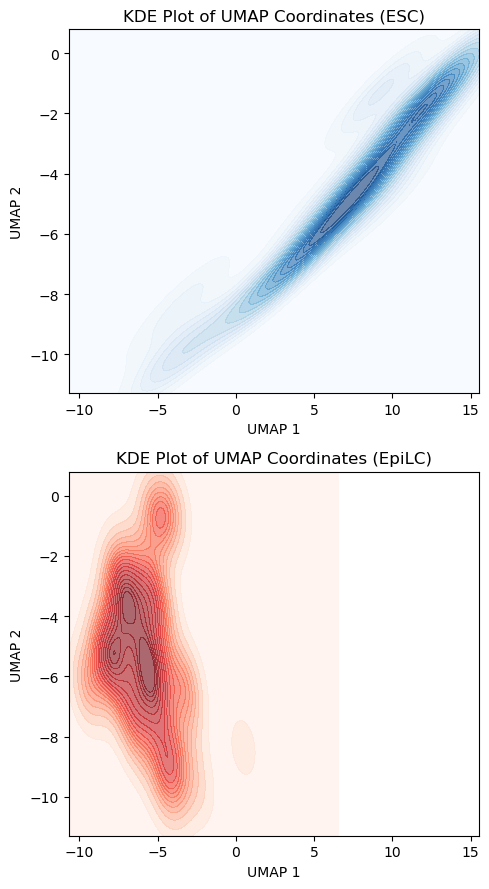

NANOG combined shape: (556, 10328)
NANOG cleaned shape: (556, 10328)


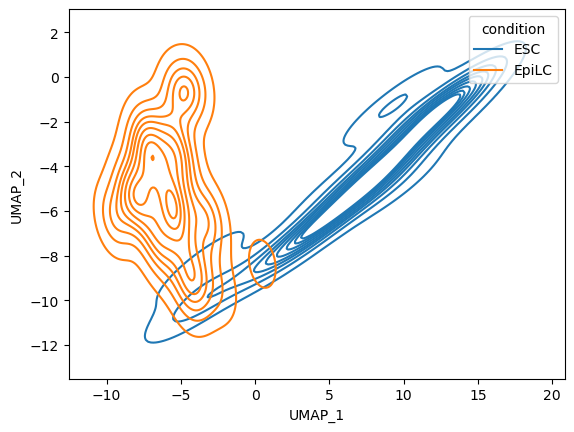

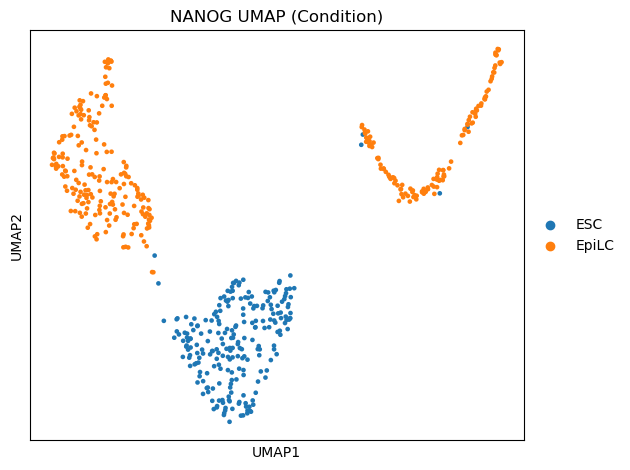

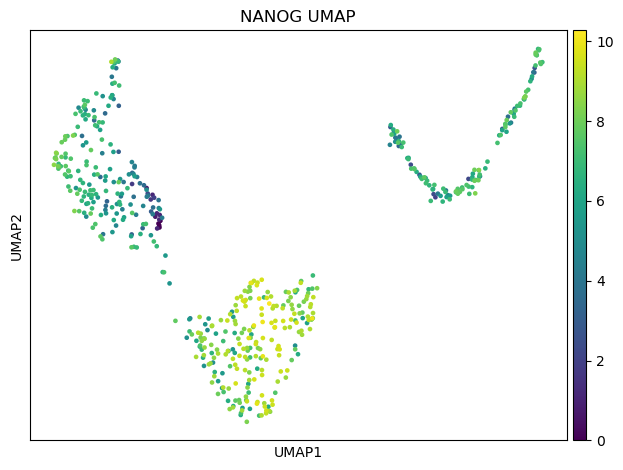

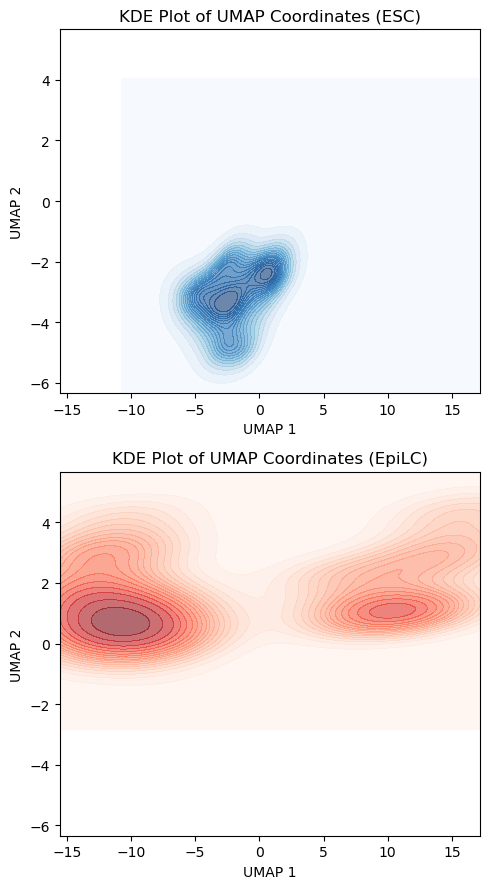

OCT4 combined shape: (563, 11041)
OCT4 cleaned shape: (563, 11041)


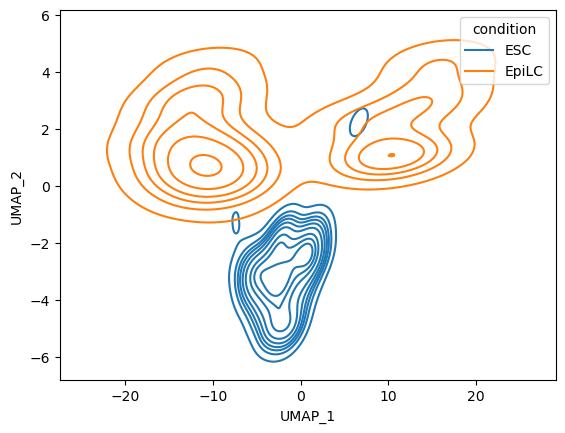

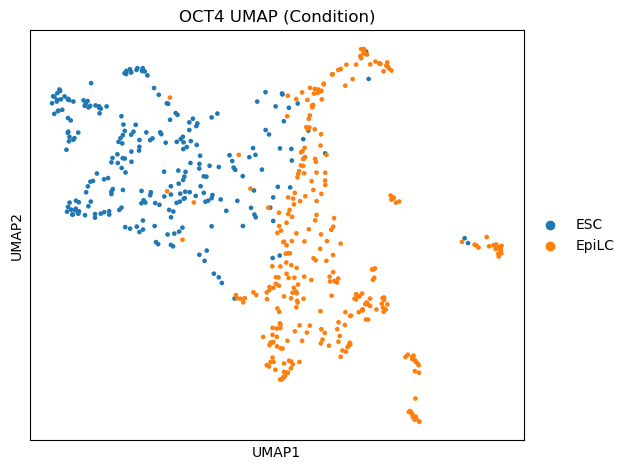

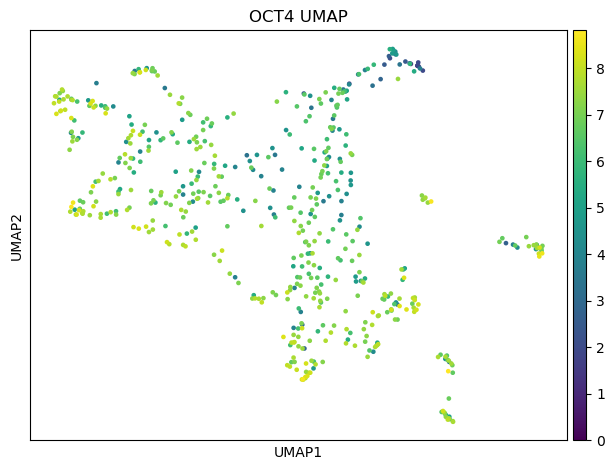

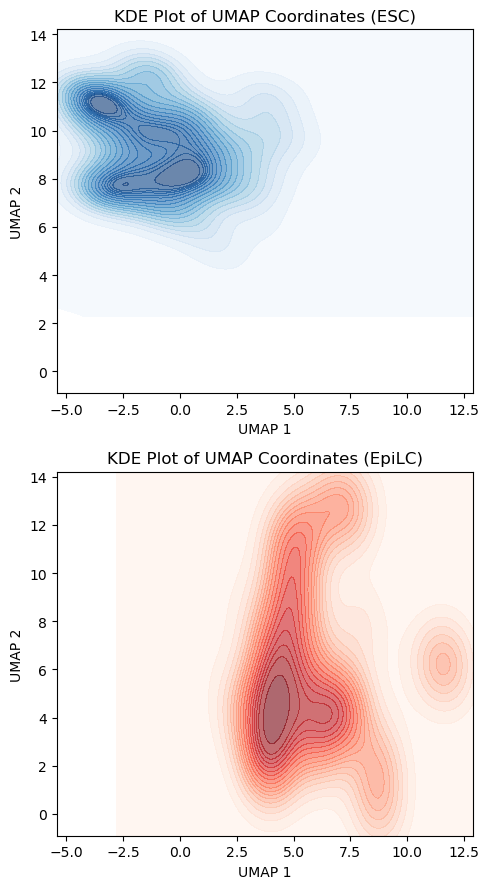

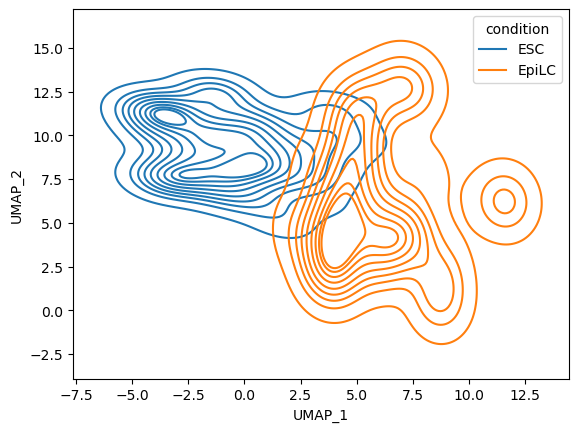

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# List of transcription factors
tfs = ["MYC", "NANOG", "OCT4"] #, "YAP1"

# Loop through each transcription factor
for tf in tfs:
    
    # Combine the datasets
    adata_filtered_combined = globals()[f"adata_{tf}_filtered_combined"]
    
    # Normalization
    #####adata_filtered_combined.obs["total_counts"] = adata_filtered_combined.obs['total_reads_percell_zscored']
    #####scales_counts_combined = sc.pp.normalize_total(adata_filtered_combined, inplace=False)
    
    # Log1p transform
    #####adata_filtered_combined.layers["log1p_norm"] = sc.pp.log1p(scales_counts_combined["X"], copy=True)
    adata_filtered_combined.layers["log1p_norm"] = sc.pp.log1p(adata_filtered_combined.layers["normalized"], copy=True)
    
    # Highly variable genes
    #####sc.pp.highly_variable_genes(adata_filtered_combined, layer="log1p_norm")
    
    print(f"{tf} combined shape:", adata_filtered_combined.shape)
    
    # Create a cleaned copy of the data
    adata_filtered_combined_clean = adata_filtered_combined.copy()
    print(f"{tf} cleaned shape:", adata_filtered_combined_clean.shape)
    
    # Replace the raw counts with log-normalized counts
    adata_filtered_combined_clean.X = adata_filtered_combined_clean.layers["log1p_norm"]
    
    # OPTIONAL: PCA (can be skipped, but improves performance with large datasets)
    if tf == "NANOG":
        sc.pp.pca(adata_filtered_combined_clean, svd_solver="arpack", n_comps=10, random_state=5) #n_comps=100#n_comps=30 #250 #600
    else:
        sc.pp.pca(adata_filtered_combined_clean, svd_solver="arpack", n_comps=10, random_state=5) #n_comps=100#n_comps=30 #50
    
    # Compute neighbors (required for both UMAP and Leiden clustering)
    if tf == "NANOG":
        sc.pp.neighbors(adata_filtered_combined_clean, n_neighbors=25, random_state=42)
    else:
        sc.pp.neighbors(adata_filtered_combined_clean, n_neighbors=25, random_state=42)
    
    # Perform Leiden clustering
    sc.tl.leiden(adata_filtered_combined_clean, resolution=0.9, random_state=42)  # Adjust resolution as needed
    
    # Perform UMAP
    if tf == "NANOG":
        sc.tl.umap(adata_filtered_combined_clean, random_state=15, min_dist=0.1, spread=1.7) #min_dist=0.5 #0.9 0.9 for NANOG
    else:
        sc.tl.umap(adata_filtered_combined_clean, random_state=15, min_dist=0.1, spread=1.7) #min_dist=0.5 #0.9 0.9 for NANOG


     # Define a filename for saving
    filename = f"{tf}_UMAP_plots.pdf"

    # Create a PDF file for storing all plots
    with PdfPages(filename) as pdf:
        # Plot UMAP with clusters
        sc.pl.umap(adata_filtered_combined_clean, color='condition', s=45, title=f'{tf} UMAP (Condition)', show=False)
        # tight layout
        plt.tight_layout()
        pdf.savefig()
        sc.pl.umap(adata_filtered_combined_clean, color='log1p_total_reads_percell_zscored', s=45, title=f'{tf} UMAP', show=False)
        plt.tight_layout()
        pdf.savefig()
    
    
    #### Storing UMAP coordinates and clustering info
    globals()[f"adata_{tf}_combined_clean"] = adata_filtered_combined_clean
    globals()[f"umap_coords_{tf}_combined"] = adata_filtered_combined_clean.obsm['X_umap']
    globals()[f"umap_df_{tf}_combined"] = adata_filtered_combined_clean.obs.copy()
    globals()[f"umap_df_{tf}_combined"][['UMAP_1', 'UMAP_2']] = globals()[f"umap_coords_{tf}_combined"]


    ##### kde plot for each TF
    #print("==============================", adata_filtered_combined_clean)
    adata_filtered_combined_clean.obs['UMAP_1'] = adata_filtered_combined_clean.obsm['X_umap'][:, 0]
    adata_filtered_combined_clean.obs['UMAP_2'] = adata_filtered_combined_clean.obsm['X_umap'][:, 1]
  
    # Filter cells by 'condition' (ESC and EpiLC)
    esc_cells = adata_filtered_combined_clean[adata_filtered_combined_clean.obs['condition'] == 'ESC']
    epilc_cells = adata_filtered_combined_clean[adata_filtered_combined_clean.obs['condition'] == 'EpiLC']

    # Create a 1x2 grid for the plots (ESC on the left, EpiLC on the right)
    fig, axes = plt.subplots(2, 1, figsize=(5, 9))

    
    # Set the axis limits based on the UMAP coordinates of the data (same for both plots)
    xlim = [adata_filtered_combined_clean.obs['UMAP_1'].min() - 1, adata_filtered_combined_clean.obs['UMAP_1'].max() + 1]
    ylim = [adata_filtered_combined_clean.obs['UMAP_2'].min() - 1, adata_filtered_combined_clean.obs['UMAP_2'].max() + 1]

    # Plot for ESC cells
    sns.kdeplot(x=esc_cells.obs['UMAP_1'], y=esc_cells.obs['UMAP_2'], cmap='Blues', fill=True, thresh=0, levels=20, alpha=0.6, ax=axes[0])
    axes[0].set_title("KDE Plot of UMAP Coordinates (ESC)")
    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)
    axes[0].set_xlabel("UMAP 1")
    axes[0].set_ylabel("UMAP 2")

    # Plot for EpiLC cells
    sns.kdeplot(x=epilc_cells.obs['UMAP_1'], y=epilc_cells.obs['UMAP_2'], cmap='Reds', fill=True, thresh=0, levels=20, alpha=0.6, ax=axes[1])
    axes[1].set_title("KDE Plot of UMAP Coordinates (EpiLC)")
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)
    axes[1].set_xlabel("UMAP 1")
    axes[1].set_ylabel("UMAP 2")

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

    sns.kdeplot(data=adata_filtered_combined_clean.obs, x="UMAP_1", y="UMAP_2", hue="condition")
    

